### Этап 1: Знакомство с данными и предобработка

In [1]:
import pandas as pd
import numpy as np
from numpy import nanmedian
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

В дата фрейме: <br> 
1) имеются пропуски<br> 
2) проработать сопрос разных типов данных в столбцах<br> 
3) необходимо скорректировать названия столбцов<br> 
4) необходимо представить дату в корректном форме 


In [2]:
#Работа с пропусками в ceiling_height

ceiling_height_median = data['ceiling_height'].median() #медиана высоты потолков. есть выбросы от 1 до 100, поэтому медиана
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median)

#Работа с пропусками в floors_total

data.isnull().sum()
query_data_floors_total = data.query('floors_total == "nan"') #во всех случаях floors_total = NaN, is_apartment также с NaN
data['floors_total'] = data['floors_total'].fillna(data['floor']) #заполнил этажом

#query_data_floors_total.info()

#Работа с пропусками в kitchen_area
query_data_kitchen_area = data.query('kitchen_area != "nan"')
kitchen_area_median = query_data_kitchen_area['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area_median)


#Работа с пропусками в living_area
query_data_living_area = data.query('living_area == "nan"')
living_area_median = data['living_area'].median()
#query_data_living_area.info() #почти все данные с выборки в is_apartment также NaN. 
#среднее по выборке 34, медиана 30. Разница несущественная, но выбрал медиану.
calculated_living_area = query_data_living_area['total_area'].median() - kitchen_area_median
data['living_area'] = data['living_area'].fillna(calculated_living_area) #заполнил данные показателем разности между медианой общей площади и медионой площади кухонь


#Работа с пропусками в is_apartment
query_data_is_apartment = data.query('is_apartment == True') #попытался посмотреть, как характеризуются апартаменты

data['is_apartment'] = data['is_apartment'].fillna(False) #заполнинл False. Если людями было бы важно, то отметили бы


#Работа с пропусками в balcony
data['balcony'] = data['balcony'].fillna(0)

#Работа с пропусками в locality_name

query_data_locality_name = data.query('locality_name == "nan"')

data.dropna(subset = ['locality_name'], inplace = True) # удалил пустые строки с неуказанными городами

#Работа с пропусками в airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest
query_auto = data.query(
    'airports_nearest == "nan"& cityCenters_nearest == "nan"& parks_around3000 == "nan"& parks_nearest =="nan"& ponds_around3000 == "nan"& ponds_nearest=="nan"')
query_data_airports_nearest = data.query('airports_nearest == "nan"')
table_airports_nearest = data[['locality_name','airports_nearest']]
airoport_median_list = data.pivot_table(index='locality_name', values='airports_nearest', aggfunc='median')

new = pd.DataFrame (airoport_median_list, columns = ['locality_name', 'airports_nearest'])
new['locality_name'] = new.index

data['days_exposition'] = data['days_exposition'].fillna(0) #раз нет инфы, то на момент формирования могло быть активным
data['ponds_nearest'] = data['ponds_nearest'].fillna(0) #возможно, прудов нет
data['parks_nearest'] = data['parks_nearest'].fillna(0) #возможно, парков нет

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

#data.isnull().sum()


#приведение к нужному типу 
data['last_price'] = data['last_price'].astype('int') #так удобнее и чтобы избежать мелких дробей
data['floors_total'] = data['floors_total'].astype('int') #не может быть дробным
data['balcony'] = data['balcony'].astype('int') #не может быть дробным
data['days_exposition'] = data['days_exposition'].astype('int')

#data.isnull().sum()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_nearest           23650 non-null float64
ponds_around3

#### Было сделано:  
  
Пропуски в ceiling_height заменены на медиану, так как есть выбросы от 1 до 100.  
Пропуски в floors_total заменены на  floor.  
Пропуски в kitchen_area заменены на медиану kitchen_area.  
Пропуски в living_area заменены на разницу медиан total_area и kitchen_area.  
Пропуски в is_apartment заменены на False. Если людями было бы важно, то отметили бы.  
Пропуски в balcony заменены на 0. Вероятно, их нет.  
Удалил строки с неуказанными городами, так как это ключевой фактор оценки цены недвижимости.   
Оставил пропуски в airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000,   ponds_nearest.   
Не ясна их природа. Обратил внимание, что почти все столбцы с автоматическим определением параметров в данном случае также пустые.   
Возможно, был сбой при формировании данных или пользователь не ввёл адрес квартиры.  
  
last_price привёл к int - для удобства  
floors_total привёл к int - не может быть дробным  
balcony привёл к int - не может быть дробным  
days_exposition привёл к int - не может быть дробным  

### Этап 2:  Формирование сводной таблицы

In [3]:
formula = data['last_price'] / data['total_area']
data['m_price'] = formula
data['m_price'] = data['m_price'].astype('int')
data['day_of_week'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year


def floor_sorting (column):
    max = column['floors_total']
    if column['floor']  == 1:
        return 'Первый'
    if (column['floor'] == max & column['floor'] != 1):
        return 'Последний'
    else:
        return 'Другой'

data['floor_sorted'] = data.apply(floor_sorting, axis = 1)
data['total_live_r'] = round(data['living_area'] / data['total_area'], 2)
data['kitchen_total_r'] = round(data['kitchen_area'] / data['total_area'], 2)
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,m_price,day_of_week,month,year,floor_sorted,total_live_r,kitchen_total_r
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2.0,755.0,0,120370,3,3,2019,Другой,0.47,0.23
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0.0,0.0,81,82920,1,12,2018,Первый,0.46,0.27
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2.0,574.0,558,92785,3,8,2015,Последний,0.61,0.15
3,0,64900000,159.0,2015-07-24,3,2.65,14,43.9,9,False,...,3.0,234.0,424,408176,4,7,2015,Другой,0.28,0.06
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1.0,48.0,121,100000,1,6,2018,Другой,0.32,0.41


### Этап 3: Исследовательский анализ данных:

Гистограма цены


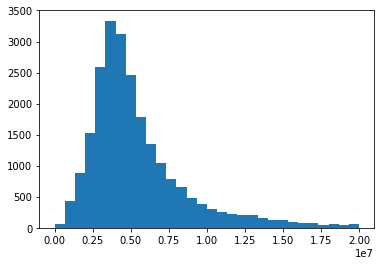

Гистограма комнат


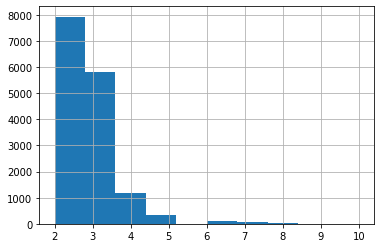

Гистограма высоты потолков


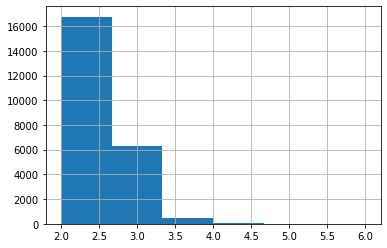

Гистограма общей площади


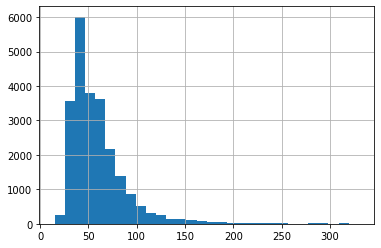

Гистограма времени размещения


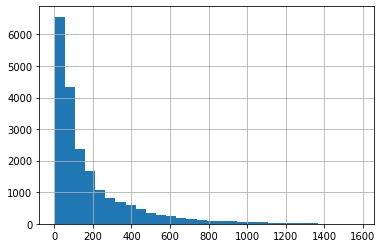

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
Размах цены в диапазоне до 60 млн
Корреляция цена/метраж обычных квартир: 0.033773659859490025
Корреляция цена/метраж дорогих квартир: -0.2331725321146652

Корреляция цена/число комнат обычных квартир: -0.17609090831186358
Корреляция цена/число комнат дорогих квартир: -0.1751544614242864

Корреляция цена/удалённость от центра обычных квартир: -0.40242195303563166
Корреляция цена/удалённость от центра дорогих квартир: -0.16555144601651337

Корреляция цена/этаж: -0.10152300052328472

Матрица корреляций good_data:
                      m_price  total_area     rooms  cityCenters_nearest  \
m_price              1.000000    0.033774 -0.176091            -0.402422   
total_area           0.033774    1.000000  0.789782            -0.116484   
rooms               -0.176091    0.789782

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


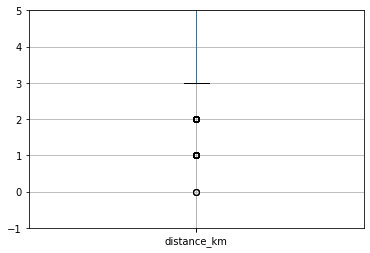

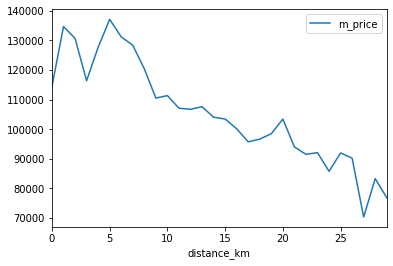

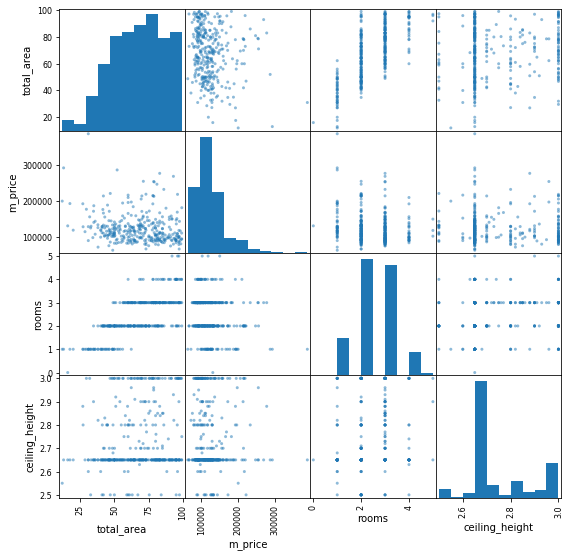


                total_area   m_price     rooms  ceiling_height
total_area        1.000000 -0.172231  0.705052        0.130141
m_price          -0.172231  1.000000 -0.162619       -0.015751
rooms             0.705052 -0.162619  1.000000        0.132032
ceiling_height    0.130141 -0.015751  0.132032        1.000000
                     last_price   m_price     rooms  floors_total  \
last_price             1.000000  0.637243  0.416561      0.091658   
m_price                0.637243  1.000000 -0.242824      0.161288   
rooms                  0.416561 -0.242824  1.000000     -0.237091   
floors_total           0.091658  0.161288 -0.237091      1.000000   
cityCenters_nearest   -0.340140 -0.352424 -0.109496      0.274473   

                     cityCenters_nearest  
last_price                     -0.340140  
m_price                        -0.352424  
rooms                          -0.109496  
floors_total                    0.274473  
cityCenters_nearest             1.000000  

          

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


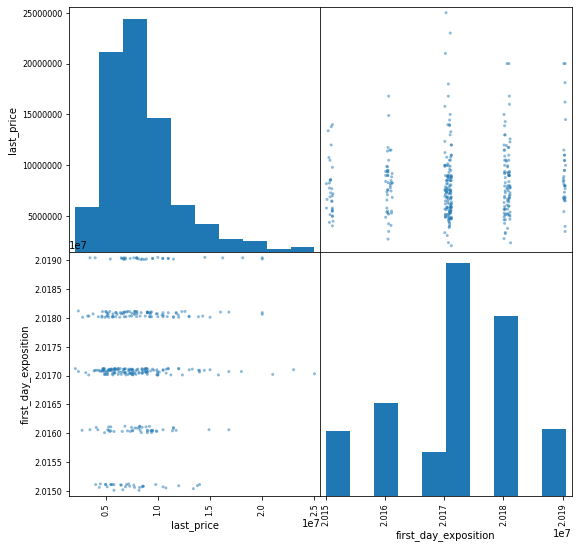

                      last_price  first_day_exposition
last_price              1.000000              0.109564
first_day_exposition    0.109564              1.000000


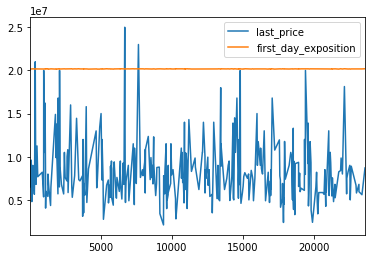

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


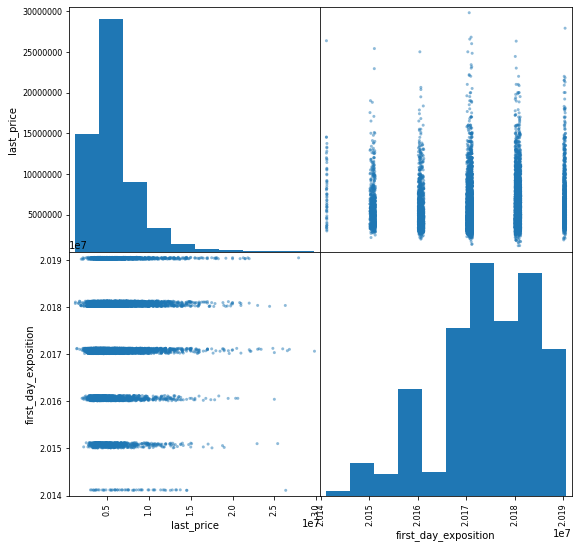

                      last_price  first_day_exposition
last_price              1.000000              0.030114
first_day_exposition    0.030114              1.000000


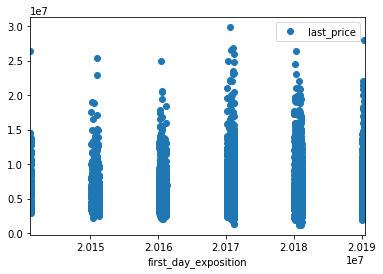


             last_price  day_of_week     month      year
last_price     1.000000    -0.007942 -0.011442  0.030228
day_of_week   -0.007942     1.000000  0.002468  0.000962
month         -0.011442     0.002468  1.000000 -0.282375
year           0.030228     0.000962 -0.282375  1.000000

             last_price  day_of_week     month      year
last_price     1.000000    -0.046065 -0.085819  0.111453
day_of_week   -0.046065     1.000000  0.088146 -0.049562
month         -0.085819     0.088146  1.000000 -0.278955
year           0.111453    -0.049562 -0.278955  1.000000



In [22]:
import matplotlib.pyplot as plt

#data['last_price'].hist(bins = 30, range = (0, 20000000))
print('Гистограма цены')
plt.hist(data['last_price'], bins = 30, range = (0, 20000000))
plt.show()
print('Гистограма комнат')
data['rooms'].hist(bins= 10, range = (2, 10))
plt.show()
print('Гистограма высоты потолков')
data['ceiling_height'].hist(bins= 6, range = (2, 6))
plt.show()
print('Гистограма общей площади')
data['total_area'].hist(bins = 30, range = (15, 330))
plt.show()

#работа с датой
print('Гистограма времени размещения')
data['days_exposition'].hist(bins= 30, range = (1,data['days_exposition'].max()))
plt.show()
sell_time_info = data.query('days_exposition>0')
sell_time_median = sell_time_info['days_exposition'].median()
sell_time_mean = sell_time_info['days_exposition'].mean()
print(sell_time_info['days_exposition'].describe())

print('Размах цены в диапазоне до 60 млн')
data.boxplot('last_price')
plt.ylim(-1, 60000000)


#формирование новой таблтицы без аномалий
good_data = data.query('last_price <= 30000000 & rooms <= 5 & ceiling_height <= 3 & total_area <100')
print('Корреляция цена/метраж обычных квартир:', good_data['m_price'].corr(good_data['total_area']))
print('Корреляция цена/метраж дорогих квартир:', expensive_flats['m_price'].corr(expensive_flats['total_area']))
print()
print('Корреляция цена/число комнат обычных квартир:', good_data['m_price'].corr(good_data['rooms']))
print('Корреляция цена/число комнат дорогих квартир:', expensive_flats['m_price'].corr(expensive_flats['rooms']))
print()
print('Корреляция цена/удалённость от центра обычных квартир:', good_data['m_price'].corr(good_data['cityCenters_nearest']))
print('Корреляция цена/удалённость от центра дорогих квартир:', expensive_flats['m_price'].corr(expensive_flats['cityCenters_nearest']))
print()

def floor_sort_numbers (column):
    max = column['floors_total']
    if column['floor_sorted']  == 'Другой':
        return 0
    if column['floor_sorted']  == 'Первый':
        return 1
    else:
        return 2

data['floor_sorted_id'] = data.apply(floor_sort_numbers, axis = 1)

good_data['last_price'].corr(good_data['floor_sorted_id'])

print('Корреляция цена/этаж:', good_data['m_price'].corr(good_data['floor_sorted_id']))
print()
matrix_good_data = good_data[['m_price','total_area', 'rooms', 'cityCenters_nearest', 'day_of_week', 'month', 'year']]
#pd.plotting.scatter_matrix(matrix_good_data, figsize=(9, 9))
#plt.show()
print('Матрица корреляций good_data:')
print(matrix_good_data.corr())

#топ дорогих городов
top_locals_list = good_data['locality_name'].value_counts().head(10).index.values
top_locals_data = good_data.query('locality_name in @top_locals_list')
top_local_m_price = top_locals_data.pivot_table(index='locality_name', values='m_price', aggfunc='mean')
top_local_m_price.sort_values(by = 'm_price', ascending = False)

#добавлчем столбец с км
spb = good_data.query('locality_name == "Санкт-Петербург"')
spb['distance_km'] = round(spb['cityCenters_nearest']/1000)

center_distance_data = spb.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc=('mean', 'median'))

#смотрим размах в км
spb.boxplot('distance_km')
plt.ylim(-1, 5)
plt.show()

#сводная таблица со средней ценой кв метра и дистанции
m_price_distance_r = spb.pivot_table(index='distance_km', values='m_price', aggfunc='mean')
m_price_distance_r.plot()
plt.show()

spb_center = spb.query('distance_km <= 3')
spb_center_matrix = spb_center[['total_area','m_price','rooms','ceiling_height']]
pd.plotting.scatter_matrix(spb_center_matrix, figsize=(9, 9))
plt.show()

spb_factors = spb[['last_price', 'm_price', 'rooms', 'floors_total', 'cityCenters_nearest', 'first_day_exposition']]
spb_ceneter_factors = spb_center[[
    'last_price', 'm_price', 'rooms', 'floors_total', 'cityCenters_nearest', 'first_day_exposition']]
print()
print(spb_center_matrix.corr())
print(spb_factors.corr())
print()
print(spb_ceneter_factors.corr())
print()
print(corr_spb_ceneter_factors)
print()
print(corr_spb_factors)
print()

#проверка взаимосвязи даты и цены
spb_ceneter_factors_data = spb_ceneter_factors[['last_price', 'first_day_exposition']]
spb_ceneter_factors_data['first_day_exposition'] = spb_ceneter_factors_data['first_day_exposition'].dt.strftime("%Y%m%d").astype(int)
pd.plotting.scatter_matrix(spb_ceneter_factors_data, figsize=(9, 9))
plt.show()
print(spb_ceneter_factors_data.corr())
spb_ceneter_factors_data.plot()
plt.show()
print()
corr_date_spb = spb[['last_price','first_day_exposition']]
corr_date_spb['first_day_exposition'] = corr_date_spb['first_day_exposition'].dt.strftime("%Y%m%d").astype(int)
pd.plotting.scatter_matrix(corr_date_spb, figsize=(9, 9))
plt.show()
print(corr_date_spb.corr())
corr_date_spb.plot(x = 'first_day_exposition', y = 'last_price', style='o')
plt.show()
print()

#матрица цены и даты
spb_data_corr = spb[['last_price','day_of_week', 'month', 'year']]
print(spb_data_corr.corr())
print()

spb_center_data_corr = spb_center[['last_price','day_of_week', 'month', 'year']]
print(spb_center_data_corr.corr())
print()





## Общие выводы

**Анализ времени продаж:**<br>
Большая часть квартир продаётся в в период до 70 дней.<br>
Быстрая продажа - до 45 дней.<br>

**Аномальные значения:**<br>
Преобладающее кол-во объявления находилось в ценовой зоне до 20 млн. Однако часто встречаются предложения около 30 млн. Выше - редкость.<br>
Квартиры с 6 и более комнатами - редкость.<br>
Высота потолков более чем 3 м. встречается очень редко.<br>
Площадь квартиры выше 100 кв м встречается редко.<br>

**Какие факторы больше всего влияют на стоимость квартиры?**<br>
Стоимость квадратного метра достаточно сильно влияет на цену объекта.<br>
Самая дорогая цена кв. м. в Санкт-Петербурге.<br>
Самая низкая в Выборге.<br>

**Факторы, влияющие на цену квартир в центре:**<br>
Площадь.<br>
Количество комнат.<br>
Выяснилось, что количество комнат негативно влияет на стоимость квадратного метра квартир в центре. Вероятно, так характеризуются бывшие коммунальные квартиры.<br>
Количество этажей.<br>

**Сравнение квартир в центре СПб и за его пределами:**<br>
Количество комнат за пределами центра больше влияет на стоимость квартиры, чем в центре.<br>
Удалённость квартир в центре от центра не так сильно влияет на стоимость, в отличие от квартир за его пределами.<br>
Количество этажей в центре больше влияет на стоимость квартиры, в отличие от недвижимости за пределами центра.<br>
Год, месяц или день недели размещения объявления не влияет на цену.<br>

**Исследование по центру:**<br>
Цена квадратного метра снижается в периоде удалённость от центра 0-3 км. Затем цена начинает расти в периоде от 3 км. до 6 км. Затем снова начинает падать и имеет уже устойчивый тренд вниз.<br>
Дата размещения объявления (месяц, год, день недели) не влияет на цену квартиры.<br>
<br>
**Объекты недвижимости в центре обладают следующими характеристикам:**<br>
Малоэтажные здания. Как правило до 5 этажей. <br>
Распространённая высота потолков либо 2,6-2,7 м., либо 3 м.<br>
Количество комнат зависит от площади.<br>

**Общий вывод:**<br>
По квартирам в центре:<br>
Центр Санкт-Петербурга - округ, радиус которого равен 3 км. Стоимость квартир зависит от площади, количества комнат. Для центра количество комнат негативно влияет на цену квадратного метра, в отличие от квартир за его пределами. Также на стоимость квартиры в центре оказывает влияние количество этажей. Вероятно, в домах с этажность повыше можно встретить наличие лифта.

По всем квартирам:<br>
Настоящей удачей станет сделка на продажу квартиры в течение 45 дней с момента размещения объявления, хотя большая часть квартир реализуется в срок до 70 дней.


